This notebook is dedicated to comparing a finetuned ViT model with a custom built one including experiment tracking via w&b. If you wish to get to know ViT's architecture's caveates, you can go ahead and scroll to the 20th percentile of the notebook. First off, however, we'll need to cover some practical code that is going to come in handy along the way:

#### Creating utilities

* `plot_images()`: sampling images and displaying them with their appropriate labels
* `load_cifar()`: load and preprocess CIFAR
* `create_checkpoint()`: creates a separate directory for the new model's checkpoint

In [8]:
import torch
import torchvision
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

basepath = './data/vision/'

def plot_images(dataloader, label2title, 
                k=10, rows=1, cols=4, canvas_size=12,
                model=None, device=None, 
                labels=None):
    imgs, labels = next(iter(dataloader))

    if model is not None:
        model.eval()
        with torch.no_grad():
            labels_out = model(imgs.to(device)).cpu()
            labels = torch.softmax(labels_out,dim=1).argmax(dim=1).flatten()
        model.train()

    rand_indices = torch.randperm(imgs.shape[0])[:k]
    sample = imgs[rand_indices].cpu()
    labels_sample = labels[rand_indices].cpu()

    sample = (sample.clamp(-1,1) + 1) / 2
    sample = (sample * 255).type(torch.uint8)
    inverse_resize = T.Resize((32,32))
    sample = [inverse_resize(image) for image in sample]
    sample = torch.cat(
        [torch.cat(sample, dim=-1)],
    dim=-2).permute(1,2,0)
    sample = sample.reshape(sample.shape[0],k,sample.shape[1]//k,3).permute(1,0,2,3)

    fig, axs = plt.subplots(rows, cols, figsize=(canvas_size,canvas_size))
    for i in range(rows*cols):
        img, label = sample[i], label2title[labels_sample[i].item()]
        x, y = i % cols, i % rows
        if rows > 1 and cols > 1:
            axs[y, x].imshow(img)
            axs[y, x].set_title(label)
            axs[y, x].axis('off')
        else:
            axs[max(y, x)].imshow(img)
            axs[max(y, x)].set_title(label)
            axs[max(y, x)].axis('off')
    fig.tight_layout()
    fig.show()

def load_cifar(args):
    channel_means = (.5,.5,.5)
    channel_stds = (.5,.5,.5)

    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(512),
        torchvision.transforms.RandomResizedCrop(
            args['img_size'], scale=(.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            channel_means, channel_stds)
    ])
    dataset = torchvision.datasets.CIFAR10(
        root=f"{basepath}{args['dataset_path']}",
        train=True,
        transform=transforms,
        download=True)
    test_dataset = torchvision.datasets.CIFAR10(
        root=f"{basepath}{args['dataset_path']}",
        train=False,
        transform=transforms,
        download=True)
    dataloader = DataLoader(dataset, batch_size=args['batch_size'],
                            shuffle=True, num_workers=0)
    test_dataloader = DataLoader(test_dataset, batch_size=args['batch_size'],
                            shuffle=False, num_workers=0)
    return dataloader, test_dataloader

def create_checkpoint(run_name,
                      base_dir='wbtech_tasks', task_dir='task1/'):
    models_dir = os.path.join(base_dir,'models')
    results_dir = os.path.join(base_dir,'results')
    rundir_m, rundir_r = os.path.join(models_dir, run_name), \
        os.path.join(results_dir, run_name)

    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(rundir_m, exist_ok=True)
    os.makedirs(rundir_r, exist_ok=True)

    return rundir_m, rundir_r

#### Setting up data-related parameters
In particular we're going to be training on:
* batch sizes of $2^8$
* image sizes of $2^7$

In [11]:
# loading up the data

training_args = {
    'dataset_path': 'cifar/',
    'models_path': 'task1/',
    'batch_size': 256,
    'img_size': 128,
}

train_dl, test_dl = load_cifar(training_args)
len(train_dl), len(test_dl)

Files already downloaded and verified
Files already downloaded and verified


(196, 40)

C:\Users\user\AppData\Local\Temp\ipykernel_14984\281652573.py:61: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



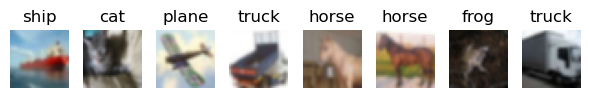

In [89]:
# displaying images

labels2title = ['plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_images(train_dl, 
            labels2title,
            k=8,cols=8,rows=1,
            canvas_size=6)

#### ViT

ViT architecture is pretty straightforward, aside from the main idea, that is a "patch-embedding". The general overview of the architecture is as follows:

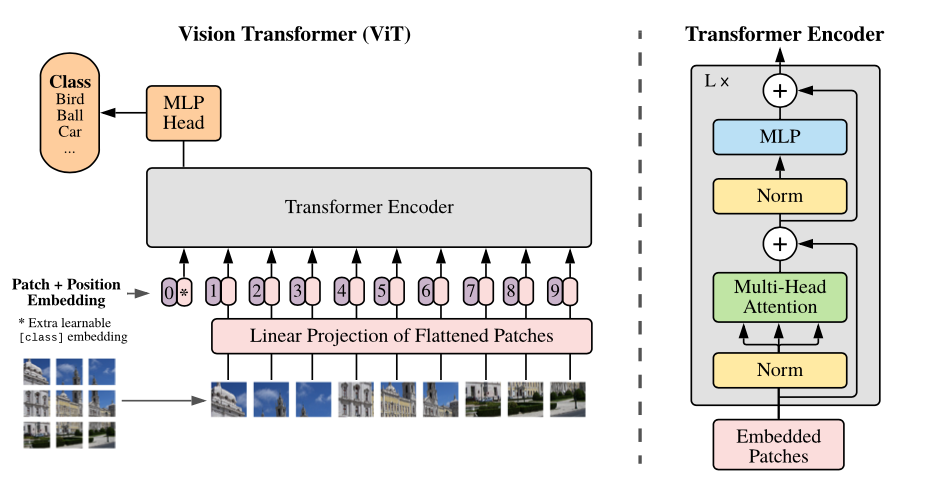

Intuitively, we treat images as texts, that have same properties of `max_seq_len` and `embed_dims` that we usually have in NLP tasks, and we're training our transformer encoder (or even some encoder-decoder) architecture on some downstream task.

#### Intuition behind the patch-embedding:
* The image needs to be represented in a `max_seq_len`x`embed_dims`. We do that by splitting our image into "flattened patches" (small image parts of size $patch_{size}\times patch_{size}$) via some convolution;
* Having specified the $patch_{size}$ we also explicitely define the number of output channels that is equal to `embed_dims`. Thanks to convolution we have sequentially ordered values in a $patch_{size}\times patch_{size}$ matrix that we then flatten out to get the actual patch-embedding.  Hence, we move from representing images as $C\times H\times W$ to $patch_{size}\times D$, where $patch_{size}$ serves a role of the `max_seq_len`, as stated before:

    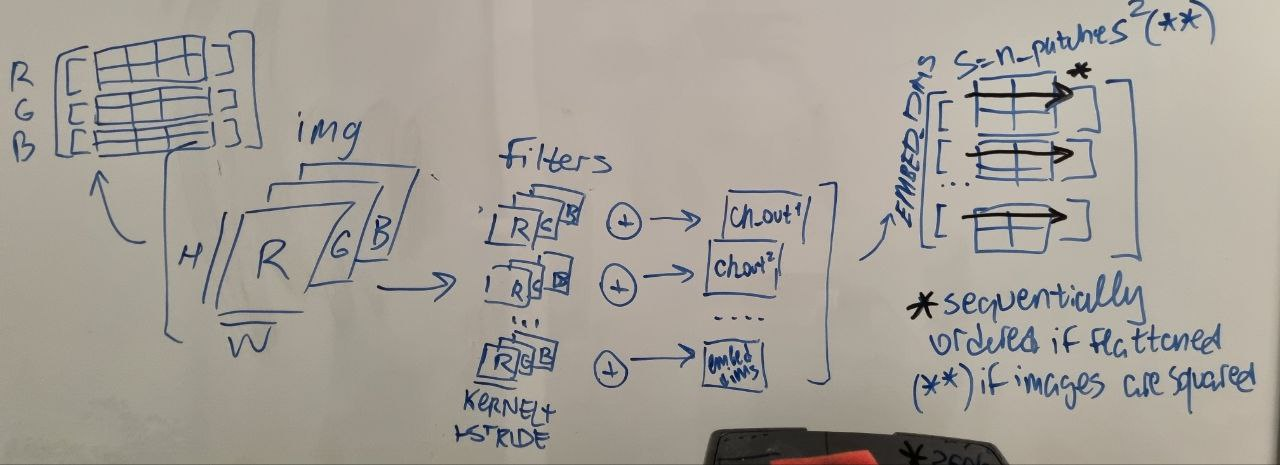

In [4]:
from torch import nn
import torch.functional as F

training_args['ch_in'] = 3
training_args['patch_size'] = 16
training_args['embed_dims'] = 1024

class patchEmbedSquared(nn.Module):
  """
  Patch embedding for square images
  """

  def __init__(self, img_size, ch_in, patch_size, embed_dims):
    """
    - img_size: int
      - hxw of an image
    - ch_in: int
      - for an RGB image that would be 3
    - patch_size: int
      - size of the patch, that is also the convolution's kernel size
    - embed_dims: int
      - explicit embeddings modality
    """
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_patches =  (img_size // patch_size) ** 2

    self.proj = nn.Conv2d(
        ch_in,
        embed_dims,
        kernel_size=patch_size,
        stride=patch_size
    )

  def forward(self, x):
    """
    Returns (batch_size, n_patches, embed_dims)
    """
    x = self.proj(x)
    x = x.flatten(2)
    return x.permute(0, 2, 1)

pes = patchEmbedSquared(
    training_args['img_size'],
    training_args['ch_in'],
    training_args['patch_size'],
    training_args['embed_dims']
)

pes(next(iter(train_dl))[0]).shape

torch.Size([256, 64, 1024])

#### Embedding module

Now it's pretty much on par with the logic described in `./transformer.ipynb`. We combine our contextual embedding with the position one. Here we use a classic sinusoidal positional embedding. Note that we also append a special $[CLS]$ token to our embedding (hence you might see something like this: `self.context_length + 1`), just like in BERT. We do this, because we're going to train our model on the downstream classification task and we're going to get logits explicitely from the first row of the embedding matrix that corresponds to the $[CLS]$ token:

In [5]:
# positional Embedding module

class Embedding(nn.Module):

  def __init__(self, img_size, ch_in,
               patch_size, embed_dims,
               dropout=.2, log_base=10_000,
               device='cpu'):
    super().__init__()
    self.device = device
    self.log_base = torch.tensor(log_base)
    self.embed_dims = embed_dims
    self.context_length = (img_size // patch_size) ** 2
    self.cls_token_embed = nn.Embedding(1,embed_dims)
    self.pes = patchEmbedSquared(
        img_size, ch_in, patch_size, embed_dims
    )
    self.dropout = nn.Dropout(dropout)

  def gen_pos_embed(self):
    image_context_and_cls = self.context_length + 1
    position = torch.arange(image_context_and_cls).unsqueeze(1)
    inf_freq = torch.exp(torch.arange(0, self.embed_dims, 2) * \
                         (-torch.log(self.log_base) / self.embed_dims))
    pe = torch.zeros(image_context_and_cls, 1, self.embed_dims)
    pe[:, 0, 0::2] = torch.sin(position * inf_freq)
    pe[:, 0, 1::2] = torch.cos(position * inf_freq)
    return pe.permute(1,0,2)

  def forward(self, x):
    x = self.pes(x)
    batch_size, context_len = x.shape[0], x.shape[1]
    pos_x = self.gen_pos_embed().expand(
        batch_size, context_len+1, self.embed_dims
    ).to(self.device)
    cls_x = self.cls_token_embed(
        torch.zeros(pos_x.shape[0], 1).type(torch.int).to(self.device))
    x = torch.cat([cls_x, x], dim=-2)
    return self.dropout(x + pos_x)

emb = Embedding(
    training_args['img_size'],
    training_args['ch_in'],
    training_args['patch_size'],
    training_args['embed_dims'],
)
emb(next(iter(train_dl))[0]).shape

torch.Size([256, 65, 1024])

#### Building an actual ViT

Now we combine the transformer encoder with our embedding representation of an image as well as a linear layer on top , which we also run through a softmax function in order to yeild a probability distribution for each of the `num_classes`. Such idea can be also observed in `./mha_classifier.ipynb`, where we basically build all this logic from the ground-up:

In [6]:


class vit(nn.Module):

  def __init__(self, img_size, ch_in,
               patch_size, embed_dims,
               num_classes,class_w=None,
               num_heads=6, num_blocks=3,
               dropout=.1, log_base=10_000,
               device='cpu'):
    super().__init__()

    self.context_length = (img_size // patch_size) ** 2
    self.emb = Embedding(img_size, ch_in, patch_size,
                         embed_dims, dropout, log_base, device)
    self.norm = nn.LayerNorm(embed_dims)
    self.encoder_block = nn.TransformerEncoderLayer(embed_dims, num_heads,
                                                    batch_first=True)
    self.encoder_blocks = nn.TransformerEncoder(self.encoder_block, num_blocks,
                                                self.norm)
    self.fc_out = nn.Linear(embed_dims, num_classes)


  def forward(self, x):
    x = self.emb(x)
    x = self.encoder_blocks(x)
    out = self.fc_out(x)[:,0]
    return out

training_args['num_classes'] = 10
training_args['num_heads'] = 16
training_args['dropout'] = .1
training_args['num_blocks'] = 1
training_args['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

vit_model = vit(
    training_args['img_size'],
    training_args['ch_in'],
    training_args['patch_size'],
    training_args['embed_dims'],
    training_args['num_classes'],
    num_heads=training_args['num_heads'],
    num_blocks=training_args['num_blocks'],
    dropout=training_args['dropout'],
    device=training_args['device']
).to(training_args['device'])
vit_model

vit(
  (emb): Embedding(
    (cls_token_embed): Embedding(1, 1024)
    (pes): patchEmbedSquared(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (encoder_block): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
    )
    (linear1): Linear(in_features=1024, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=1024, bias=True)
    (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder_blocks): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (s

#### Training

Now we're ready to get down to actual training. Here are parameters that we're going to use:
* **AdamW** optimizer (as explained in [this paper](https://arxiv.org/pdf/2211.09359))
* **Cosine LR** as a LR scheduler (inspired by the same paper)
* **120 epochs**, since all the training is run on the collab free tier that is only able to train just as much 

We're also going to log all experiments using W&B, which would also help substantiate the choice for the optimizer and the scheduler:

In [8]:
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


In [13]:
# initializing training parameters

torch.cuda.empty_cache()

training_args['max_epochs'] = 200
training_args['wanb_workspace'] = 'wbtech'
training_args['verbose_level'] = 1
training_args['checkin_at'] = 5

# Adam-related parameters
training_args['lr'] = .0002
training_args['beta0'] = .9
training_args['beta1'] = .999
training_args['lambda'] = .01
optimizer = torch.optim.AdamW(
    vit_model.parameters(),
    lr=training_args['lr'],
    weight_decay=training_args['lambda']
)

# SGD-like related parameters
training_args['momentum'] = .05
sgd_optimizer = torch.optim.SGD(
    vit_model.parameters(),
    lr=training_args['lr'],
    momentum=training_args['momentum'],
    weight_decay=training_args['lambda']
)
rms_optimizer = torch.optim.RMSprop(
    vit_model.parameters(),
    lr=training_args['lr'],
    momentum=training_args['momentum'],
    weight_decay=training_args['lambda']
)

# vanilla scheduler
training_args['gamma'] = .4
training_args['patience'] = 5
lr_plateu_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=training_args['patience'], factor=training_args['gamma'])

# cosine scheduler
training_args['eta_min'] = 1e-8
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    len(train_dl),
    eta_min=training_args['eta_min'])

# exponential scheduler
exponential_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, training_args['gamma'])

# loss function
criterion = nn.CrossEntropyLoss().to(training_args['device'])

After initializing our parameters we can get down to training:

In [14]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score as acc
import wandb

wandb.init(
    project=training_args['wanb_workspace'],
    name="AdamW + cosineLR",
    config={
    "learning_rate": training_args['lr'],
    "scheduler": "cosineLR",
    "optimizer": "AdamW",
    "architecture": "ViT",
    "dataset": "CIFAR10",
    "epochs": training_args['max_epochs'],
    }
)

avLosses, accuracies = [], []

training_args['run_name'] = 'run1'

for epoch in range(training_args['max_epochs']):
    losses = []
    y, yHat = [], []
    pbar = tqdm(train_dl)
    for (img_batch, label_batch) in pbar:
        img_batch = img_batch.to(training_args['device'])
        label_batch = label_batch.to(training_args['device'])

        optimizer.zero_grad()
        out = vit_model(img_batch)
        loss = criterion(out, label_batch)
        loss.backward()
        optimizer.step()
        cosine_scheduler.step()

        pbar.set_postfix(loss=loss.item())
        losses.append(loss.detach().cpu())
        y.append(label_batch.detach().cpu())
        yHat.append(out.detach().cpu().argmax(dim=1).flatten())

    y, yHat = torch.hstack(y), torch.hstack(yHat)
    avLosses.append(torch.hstack(losses).mean().item())
    accuracies.append(acc(y,yHat))

    wandb.log({"av. loss": avLosses[-1], "accuracy": accuracies[-1]})
    if epoch % training_args['verbose_level'] == 0:
        print(f'epoch: {epoch+1} :: av. loss:',avLosses[-1],':: acc:',accuracies[-1])

    if epoch % training_args['checkin_at'] == 0:
      model_dir, _ = create_checkpoint(training_args['run_name'])
      torch.save(vit_model, os.path.join(model_dir,f'model-chekpoint{epoch}.pth'))
      print(f'registered checkpoint to model-chekpoint{epoch}.pth')

wandb.finish()

del losses
del y
del yHat
del _

accuracy,▁▆▆▅▇▇▆▆▆▇▇▇▆▇▇▇▇▇▆▇▇▆▇▇▆▇▇▇▇▇█▇█▆▆▇▇▇▇
av. loss,█▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.29156
av. loss,1.9359


100%|██████████| 196/196 [01:04<00:00,  3.03it/s, loss=1.72]


epoch: 1 :: av. loss: 1.7722456455230713 :: acc: 0.36258
registered checkpoint to model-chekpoint0.pth


100%|██████████| 196/196 [01:05<00:00,  3.00it/s, loss=1.5]


epoch: 2 :: av. loss: 1.5608993768692017 :: acc: 0.44346


100%|██████████| 196/196 [01:05<00:00,  3.01it/s, loss=1.44]


epoch: 3 :: av. loss: 1.4756748676300049 :: acc: 0.47268


100%|██████████| 196/196 [01:04<00:00,  3.02it/s, loss=1.36]


epoch: 4 :: av. loss: 1.4219121932983398 :: acc: 0.4939


100%|██████████| 196/196 [01:05<00:00,  3.01it/s, loss=1.23]


epoch: 5 :: av. loss: 1.3762725591659546 :: acc: 0.50662


100%|██████████| 196/196 [01:05<00:00,  3.00it/s, loss=1.16]


epoch: 6 :: av. loss: 1.335493803024292 :: acc: 0.5232
registered checkpoint to model-chekpoint5.pth


100%|██████████| 196/196 [01:05<00:00,  3.00it/s, loss=1.1]


epoch: 7 :: av. loss: 1.3063454627990723 :: acc: 0.53322


100%|██████████| 196/196 [01:05<00:00,  3.01it/s, loss=1.05]


epoch: 8 :: av. loss: 1.2788214683532715 :: acc: 0.5454


100%|██████████| 196/196 [01:05<00:00,  3.00it/s, loss=0.993]


epoch: 9 :: av. loss: 1.2528901100158691 :: acc: 0.55112


100%|██████████| 196/196 [01:04<00:00,  3.02it/s, loss=0.953]


epoch: 10 :: av. loss: 1.2308721542358398 :: acc: 0.56216


100%|██████████| 196/196 [01:05<00:00,  3.01it/s, loss=0.858]


epoch: 11 :: av. loss: 1.207005500793457 :: acc: 0.56918
registered checkpoint to model-chekpoint10.pth


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.933]


epoch: 12 :: av. loss: 1.1842973232269287 :: acc: 0.5778


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.798]


epoch: 13 :: av. loss: 1.1661500930786133 :: acc: 0.58542


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.752]


epoch: 14 :: av. loss: 1.148798942565918 :: acc: 0.59252


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.732]


epoch: 15 :: av. loss: 1.1283552646636963 :: acc: 0.5983


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.675]


epoch: 16 :: av. loss: 1.1202874183654785 :: acc: 0.60378
registered checkpoint to model-chekpoint15.pth


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.649]


epoch: 17 :: av. loss: 1.1029794216156006 :: acc: 0.60876


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.66]


epoch: 18 :: av. loss: 1.0778735876083374 :: acc: 0.61566


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.592]


epoch: 19 :: av. loss: 1.0642708539962769 :: acc: 0.62234


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.59]


epoch: 20 :: av. loss: 1.0513004064559937 :: acc: 0.62558


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.563]


epoch: 21 :: av. loss: 1.0324214696884155 :: acc: 0.63272
registered checkpoint to model-chekpoint20.pth


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.575]


epoch: 22 :: av. loss: 1.012804388999939 :: acc: 0.63888


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.473]


epoch: 23 :: av. loss: 1.001852035522461 :: acc: 0.64628


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.472]


epoch: 24 :: av. loss: 0.9826152324676514 :: acc: 0.6538


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.439]


epoch: 25 :: av. loss: 0.9650673866271973 :: acc: 0.6583


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.328]


epoch: 26 :: av. loss: 0.9482241272926331 :: acc: 0.66462
registered checkpoint to model-chekpoint25.pth


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.32]


epoch: 27 :: av. loss: 0.9274145364761353 :: acc: 0.67198


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.359]


epoch: 28 :: av. loss: 0.9142311215400696 :: acc: 0.67752


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.369]


epoch: 29 :: av. loss: 0.8973316550254822 :: acc: 0.6821


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.339]


epoch: 30 :: av. loss: 0.884339451789856 :: acc: 0.68748


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.324]


epoch: 31 :: av. loss: 0.8657110333442688 :: acc: 0.6956
registered checkpoint to model-chekpoint30.pth


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.288]


epoch: 32 :: av. loss: 0.8606047630310059 :: acc: 0.69812


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.265]


epoch: 33 :: av. loss: 0.8519893288612366 :: acc: 0.70014


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.259]


epoch: 34 :: av. loss: 0.8347249031066895 :: acc: 0.70596


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.357]


epoch: 35 :: av. loss: 0.8195397257804871 :: acc: 0.71328


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.254]


epoch: 36 :: av. loss: 0.8125361800193787 :: acc: 0.71528
registered checkpoint to model-chekpoint35.pth


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.212]


epoch: 37 :: av. loss: 0.7972913980484009 :: acc: 0.72112


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.248]


epoch: 38 :: av. loss: 0.7715179324150085 :: acc: 0.73034


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.209]


epoch: 39 :: av. loss: 0.7621293067932129 :: acc: 0.7339


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.193]


epoch: 40 :: av. loss: 0.7461633682250977 :: acc: 0.73994


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.187]


epoch: 41 :: av. loss: 0.7305365800857544 :: acc: 0.74634
registered checkpoint to model-chekpoint40.pth


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.18]


epoch: 42 :: av. loss: 0.7236368656158447 :: acc: 0.74914


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.147]


epoch: 43 :: av. loss: 0.7054219245910645 :: acc: 0.75478


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.14]


epoch: 44 :: av. loss: 0.6886298656463623 :: acc: 0.76322


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.148]


epoch: 45 :: av. loss: 0.6785197854042053 :: acc: 0.76536


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.106]


epoch: 46 :: av. loss: 0.6659904718399048 :: acc: 0.76912
registered checkpoint to model-chekpoint45.pth


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.105]


epoch: 47 :: av. loss: 0.6547600626945496 :: acc: 0.77368


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.127]


epoch: 48 :: av. loss: 0.6341705918312073 :: acc: 0.7827


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.122]


epoch: 49 :: av. loss: 0.6315411925315857 :: acc: 0.78222


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.105]


epoch: 50 :: av. loss: 0.6136957406997681 :: acc: 0.79126


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.11]


epoch: 51 :: av. loss: 0.6005756855010986 :: acc: 0.79314
registered checkpoint to model-chekpoint50.pth


100%|██████████| 196/196 [01:05<00:00,  2.99it/s, loss=0.133]


epoch: 52 :: av. loss: 0.5914677381515503 :: acc: 0.79788


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.133]


epoch: 53 :: av. loss: 0.5805776119232178 :: acc: 0.8024


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.0942]


epoch: 54 :: av. loss: 0.5587921738624573 :: acc: 0.80962


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.101]


epoch: 55 :: av. loss: 0.553625762462616 :: acc: 0.8119


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0907]


epoch: 56 :: av. loss: 0.5536140203475952 :: acc: 0.81296
registered checkpoint to model-chekpoint55.pth


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.068]


epoch: 57 :: av. loss: 0.5385279655456543 :: acc: 0.81664


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0848]


epoch: 58 :: av. loss: 0.5367729067802429 :: acc: 0.81952


100%|██████████| 196/196 [01:06<00:00,  2.94it/s, loss=0.0838]


epoch: 59 :: av. loss: 0.519321084022522 :: acc: 0.82234


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.105]


epoch: 60 :: av. loss: 0.5252547860145569 :: acc: 0.82294


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.091]


epoch: 61 :: av. loss: 0.5106920003890991 :: acc: 0.82682
registered checkpoint to model-chekpoint60.pth


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.0765]


epoch: 62 :: av. loss: 0.5039688944816589 :: acc: 0.8279


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.12]


epoch: 63 :: av. loss: 0.5029413104057312 :: acc: 0.83128


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.0695]


epoch: 64 :: av. loss: 0.48766228556632996 :: acc: 0.83556


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0639]


epoch: 65 :: av. loss: 0.48859333992004395 :: acc: 0.83638


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0728]


epoch: 66 :: av. loss: 0.4742394983768463 :: acc: 0.84062
registered checkpoint to model-chekpoint65.pth


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0771]


epoch: 67 :: av. loss: 0.48059993982315063 :: acc: 0.83782


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.103]


epoch: 68 :: av. loss: 0.46007299423217773 :: acc: 0.84564


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0701]


epoch: 69 :: av. loss: 0.4635159373283386 :: acc: 0.84428


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.0424]


epoch: 70 :: av. loss: 0.4478009343147278 :: acc: 0.85026


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0678]


epoch: 71 :: av. loss: 0.4497879147529602 :: acc: 0.84868
registered checkpoint to model-chekpoint70.pth


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0578]


epoch: 72 :: av. loss: 0.4397132992744446 :: acc: 0.84934


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0866]


epoch: 73 :: av. loss: 0.43680840730667114 :: acc: 0.8535


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0263]


epoch: 74 :: av. loss: 0.4256058633327484 :: acc: 0.85776


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0825]


epoch: 75 :: av. loss: 0.4223569631576538 :: acc: 0.86016


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0632]


epoch: 76 :: av. loss: 0.41800418496131897 :: acc: 0.85934
registered checkpoint to model-chekpoint75.pth


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0415]


epoch: 77 :: av. loss: 0.4177238941192627 :: acc: 0.8593


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.106]


epoch: 78 :: av. loss: 0.40782275795936584 :: acc: 0.86338


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0362]


epoch: 79 :: av. loss: 0.3953203558921814 :: acc: 0.86886


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.054]


epoch: 80 :: av. loss: 0.3930763602256775 :: acc: 0.86938


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0749]


epoch: 81 :: av. loss: 0.39195114374160767 :: acc: 0.86852
registered checkpoint to model-chekpoint80.pth


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0365]


epoch: 82 :: av. loss: 0.3881925344467163 :: acc: 0.87034


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0275]


epoch: 83 :: av. loss: 0.38115766644477844 :: acc: 0.87204


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0355]


epoch: 84 :: av. loss: 0.36850446462631226 :: acc: 0.87658


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0461]


epoch: 85 :: av. loss: 0.36927667260169983 :: acc: 0.87542


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0518]


epoch: 86 :: av. loss: 0.36226338148117065 :: acc: 0.87782
registered checkpoint to model-chekpoint85.pth


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0511]


epoch: 87 :: av. loss: 0.35655924677848816 :: acc: 0.88034


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0362]


epoch: 88 :: av. loss: 0.35938432812690735 :: acc: 0.87922


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.034]


epoch: 89 :: av. loss: 0.35138043761253357 :: acc: 0.88316


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0811]


epoch: 90 :: av. loss: 0.3574964106082916 :: acc: 0.8781


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0195]


epoch: 91 :: av. loss: 0.3462751805782318 :: acc: 0.88256
registered checkpoint to model-chekpoint90.pth


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0335]


epoch: 92 :: av. loss: 0.3401247262954712 :: acc: 0.88654


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0646]


epoch: 93 :: av. loss: 0.3366927206516266 :: acc: 0.8864


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0727]


epoch: 94 :: av. loss: 0.33738699555397034 :: acc: 0.8879


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0899]


epoch: 95 :: av. loss: 0.3360525965690613 :: acc: 0.88726


100%|██████████| 196/196 [01:06<00:00,  2.94it/s, loss=0.0421]


epoch: 96 :: av. loss: 0.32934197783470154 :: acc: 0.88984
registered checkpoint to model-chekpoint95.pth


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.0233]


epoch: 97 :: av. loss: 0.3227565586566925 :: acc: 0.89156


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.021]


epoch: 98 :: av. loss: 0.3168012797832489 :: acc: 0.89378


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0293]


epoch: 99 :: av. loss: 0.3116321563720703 :: acc: 0.89548


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0359]


epoch: 100 :: av. loss: 0.30720385909080505 :: acc: 0.89584


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0248]


epoch: 101 :: av. loss: 0.30433160066604614 :: acc: 0.89758
registered checkpoint to model-chekpoint100.pth


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0302]


epoch: 102 :: av. loss: 0.2969401478767395 :: acc: 0.90024


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0949]


epoch: 103 :: av. loss: 0.3017866313457489 :: acc: 0.89904


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0226]


epoch: 104 :: av. loss: 0.29677584767341614 :: acc: 0.90082


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0207]


epoch: 105 :: av. loss: 0.294922798871994 :: acc: 0.90082


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0322]


epoch: 106 :: av. loss: 0.28101012110710144 :: acc: 0.90532
registered checkpoint to model-chekpoint105.pth


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.0736]


epoch: 107 :: av. loss: 0.284931480884552 :: acc: 0.90434


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0283]


epoch: 108 :: av. loss: 0.2819102108478546 :: acc: 0.90546


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0194]


epoch: 109 :: av. loss: 0.28484442830085754 :: acc: 0.90476


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0151]


epoch: 110 :: av. loss: 0.2748737633228302 :: acc: 0.90842


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.04]


epoch: 111 :: av. loss: 0.2708743214607239 :: acc: 0.90798
registered checkpoint to model-chekpoint110.pth


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0279]


epoch: 112 :: av. loss: 0.26977428793907166 :: acc: 0.9084


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0297]


epoch: 113 :: av. loss: 0.26783445477485657 :: acc: 0.90944


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.02]


epoch: 114 :: av. loss: 0.2643987834453583 :: acc: 0.91282


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0557]


epoch: 115 :: av. loss: 0.25982680916786194 :: acc: 0.91256


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.00809]


epoch: 116 :: av. loss: 0.2567960321903229 :: acc: 0.91294
registered checkpoint to model-chekpoint115.pth


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0134]


epoch: 117 :: av. loss: 0.25919586420059204 :: acc: 0.91242


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.0759]


epoch: 118 :: av. loss: 0.2555423378944397 :: acc: 0.9142


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.023]


epoch: 119 :: av. loss: 0.25659307837486267 :: acc: 0.91382


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0207]


epoch: 120 :: av. loss: 0.2557052671909332 :: acc: 0.91512


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0248]


epoch: 121 :: av. loss: 0.24704843759536743 :: acc: 0.91614
registered checkpoint to model-chekpoint120.pth


 15%|█▍        | 29/196 [00:10<00:58,  2.83it/s, loss=0.0969]


KeyboardInterrupt: 

For good measure we're also going to save our results inside the `.h5` dataset:

In [ ]:
# сохраним результаты метрик в .h5 датасет

metrics_file_path ='./runs/cv/results/cifar_vit.h5'
metrics_file_path = f'./wbtech_tasks/results/'\
    f'{training_args["run_name"]}/metrics.h5'

In [15]:
import h5py
import numpy as np

accuracies, avLosses = np.array(accuracies), \
    np.array(avLosses)
h5f = h5py.File(metrics_file_path, 'w')
h5f.create_dataset('acc', data=accuracies)
h5f.create_dataset('loss', data=avLosses)
h5f.close()

#### Results
AdamW+cosine scheduler proved to be quite efficient in producing close-to-SOTA 90%+ results:

In [7]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import h5py

epochs_range = list(range(120))
with h5py.File(metrics_file_path, 'r') as f:
    avLosses, accuracies = f['loss'][:], f['acc'][:]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('loss', 'accuracy'))
fig.add_trace(
    go.Scatter(x=epochs_range, y=avLosses),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=epochs_range, y=accuracies),
    row=1, col=2
)

fig.update_layout(height=300, width=600,
                  title_text="Кривые обучения",
                  showlegend=False)
fig.show()

Moreover quite a bunch of experiments, including other schedulers and optimizers, have been conducted, and only one of them provided a good top-1 accuracy on a small dataset, that is `cifar10/train` as well as quite a weak ViT architecture (just one encoder-block,absolute positional embedding etc.):

In [90]:
from IPython.display import IFrame

url_to_report = 'https://wandb.ai/turkunov/wbtech/reports/wbtask_1-ViT-results--Vmlldzo4MjY1MzQ0?accessToken=v6d0m7cqbi4j176gh31jcyake1no2ma4xpb9i3gbt3l0o6gdfc7h5vb3ka9dm9sm'
IFrame(url_to_report, width=600, height=300)

We can then run our latest checkpoint on some data from the same set:

c:\Users\user\miniconda3\envs\intensive\Lib\site-packages\torch\nn\modules\transformer.py:720: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._transformer_encoder_layer_fwd(
C:\Users\user\AppData\Local\Temp\ipykernel_4984\2871247144.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


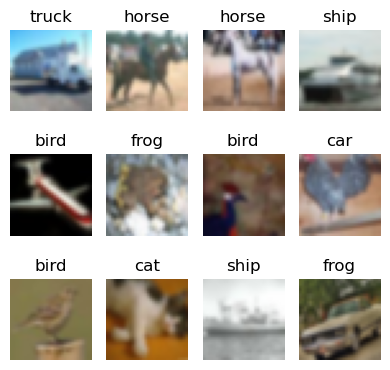

In [7]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
path_to_model = './runs/cv/models/vit/cifar10_vit.pth'
labels2title = ['plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
vit_model = torch.load(path_to_model)
plot_images(
    dataloader=train_dl, 
    label2title=labels2title, 
    k=12, 
    rows=3, cols=4, 
    canvas_size=4, 
    model=vit_model, 
    device=device)

Next step is performing zero-shot predictions on the unobserved test set of the data:

In [24]:
from sklearn.metrics import accuracy_score as acc
import torch.nn.functional as F

y_pred, y_true = [], []

torch.cuda.empty_cache()
pbar = tqdm(test_dl)
vit_model.train()
for (imgs, labels) in pbar:

    # vit_model.eval()
    with torch.no_grad():
        labels_out = vit_model(imgs.to(device)).cpu()
        labels_out = F.softmax(labels_out,dim=1).argmax(dim=1).flatten()

    y_pred += labels_out.tolist()
    y_true += labels.flatten().tolist()
    # pbar.set_postfix(accuracy=curAccuracy)

curAccuracy = acc(y_true,y_pred)
print(f'test accuracy: {curAccuracy}')
None

100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

test accuracy: 0.5689


#### Finetuning ViT
Now we can transition to finetuning a pretrained ViT. In our case that would be a popular model by Google: https://huggingface.co/google/vit-base-patch16-224-in21k. We will use LoRA for finetuning without any quantizations. Before that, however, we need to transform our images to $224\times224$. For that matter we'll rewrite our original `load_cifar()` as `load_cifar_for_finetune()`:

In [3]:
from datasets import Dataset

def load_cifar_for_finetune(args):
    channel_means = (.5,.5,.5)
    channel_stds = (.5,.5,.5)

    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(512),
        torchvision.transforms.RandomResizedCrop(
            224, scale=(.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            channel_means, channel_stds)
    ])
    dataset = torchvision.datasets.CIFAR10(
        root=f"{basepath}{args['dataset_path']}",
        train=True,
        transform=transforms,
        download=True)
    return dataset

train_dl_finetuning = load_cifar_for_finetune(training_args)
len(train_dl_finetuning)

Files already downloaded and verified


50000

Now lets initialize our LoRA adapter which will utilize:
* just the rank of $16$
* $\alpha_{LoRA}=16$
* only $Q,V$ matrices unfrozen

In [102]:
# % of trainable parameters utility func

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"обучаемые параметры модели: {trainable_params} || все параметры: {all_param} || обучаемых%: {100 * trainable_params / all_param:.2f}")

In [103]:
# init the LoRA adapter

from peft import LoraConfig, get_peft_model
from transformers import ViTForImageClassification

labels2title = ['plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model_name = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels2title),
    id2label={i: c for i, c in enumerate(labels2title)},
    label2id={c: i for i, c in enumerate(labels2title)}
)

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


обучаемые параметры модели: 597514 || все параметры: 86403860 || обучаемых%: 0.69


#### Initializing the trainer

Trainer is going to store all necessary training config parameters accessed during trainer. Note that in order to adapt our data for huggingface trainer's API we'll need to initialize some helpers:
* `compute_metrics()`: a classic accuracy compute for multiclass data
* `collate_fn()`: instead of a batch of tuples we'll return an expected (by the original model) data template as a dictionary, where pixel values of an image are stored in `pixel_values` key and its corresponding label - in `labels`:

In [6]:
from transformers import TrainingArguments
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x[0] for x in batch]),
        'labels': torch.tensor([x[1] for x in batch])
    }

batch_size = 16
num_epochs = 300

args = TrainingArguments(
    f"./runs/cv/models/vit/finetuned/cifar_lora/",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    report_to='wandb',
    max_steps=num_epochs,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    label_names=["labels"],
)

#### Running finetuning

Finetuning training parameters are as follows:
* $\eta_0=.0002$
* `batch_size=16`
* `num_epochs=300`
* `gradient_accumulation_steps=4` (saving optimizer's state every 4th epoch)

In [7]:
from transformers import Trainer, TrainerCallback
from transformers import AutoImageProcessor
from copy import deepcopy

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)

        if "labels" in inputs:
            preds = outputs.logits.detach()
            acc = (
                (preds.argmax(axis=1) == inputs["labels"])
                .type(torch.float)
                .mean()
                .item()
            )
            self.log({"accuracy": acc})

        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

        return (loss, outputs) if return_outputs else loss

image_processor = AutoImageProcessor.from_pretrained(model_name)

torch.cuda.empty_cache()

trainer = CustomTrainer(
    lora_model,
    args,
    train_dataset=train_dl_finetuning,
    eval_dataset=train_dl_finetuning,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yturkunov (turkunov). Use `wandb login --relogin` to force relogin


  0%|          | 0/300 [00:00<?, ?it/s]

{'accuracy': 0.1875, 'epoch': 0}
{'accuracy': 0.1875, 'epoch': 0}
{'accuracy': 0.1875, 'epoch': 0}
{'accuracy': 0.0625, 'epoch': 0}
{'accuracy': 0.0, 'epoch': 0.0}
{'accuracy': 0.0625, 'epoch': 0.0}
{'accuracy': 0.125, 'epoch': 0.0}
{'accuracy': 0.25, 'epoch': 0.0}
{'accuracy': 0.125, 'epoch': 0.0}
{'accuracy': 0.125, 'epoch': 0.0}
{'accuracy': 0.1875, 'epoch': 0.0}
{'accuracy': 0.1875, 'epoch': 0.0}
{'accuracy': 0.125, 'epoch': 0.0}
{'accuracy': 0.1875, 'epoch': 0.0}
{'accuracy': 0.125, 'epoch': 0.0}
{'accuracy': 0.125, 'epoch': 0.0}
{'accuracy': 0.125, 'epoch': 0.01}
{'accuracy': 0.1875, 'epoch': 0.01}
{'accuracy': 0.4375, 'epoch': 0.01}
{'accuracy': 0.375, 'epoch': 0.01}
{'accuracy': 0.375, 'epoch': 0.01}
{'accuracy': 0.125, 'epoch': 0.01}
{'accuracy': 0.125, 'epoch': 0.01}
{'accuracy': 0.375, 'epoch': 0.01}
{'accuracy': 0.1875, 'epoch': 0.01}
{'accuracy': 0.25, 'epoch': 0.01}
{'accuracy': 0.375, 'epoch': 0.01}
{'accuracy': 0.3125, 'epoch': 0.01}
{'accuracy': 0.375, 'epoch': 0.01}
{

  0%|          | 0/3125 [00:00<?, ?it/s]

{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 0.875, 'epoch': 0.38}
{'accuracy': 0.9375, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 0.9375, 'epoch': 0.38}
{'accuracy': 0.9375, 'epoch': 0.38}
{'accuracy': 0.875, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 0.9375, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 0.9375, 'epoch': 0.38}
{'accuracy': 0.9375, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 0.9375, 

KeyboardInterrupt: 

Unsuprisingly enough, finetuing with LoRA a pretrained heavy-weight ViT that has observed a more diverse sample (ImageNet) on more epochs has yeilded a much better results of $96\%+$. Interestingly enough, with these kinds of results, it was even able to train almost 10 times faster than our custom model:

In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

loss = list(filter(lambda x: x is not None, list(map(lambda x: None if 'loss' not in x.keys() else x['loss'], trainer.state.log_history))))
log_hist = pd.DataFrame(trainer.state.log_history)
accuracy = log_hist['accuracy'].dropna()[:300:5].tolist()

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('loss', 'accuracy'))


fig.add_trace(
    go.Scatter(x=list(range(1,31)), y=loss),
    row=1, col=1
)
fig.update_xaxes(title_text="epoch/10", row=1, col=1)

fig.add_trace(
    go.Scatter(x=list(range(1,301,5)), y=accuracy),
    row=1, col=2
)
fig.update_xaxes(title_text="epoch/5", row=1, col=2)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.show()

This model is far from SOTA solutions, but it's good enough to publish to HF hub, which we can do with a pretty simple command:

In [31]:
import os
from dotenv import load_dotenv

load_dotenv()

repo_name = f"yturkunov/cifar10_vit16_lora"
lora_model.push_to_hub(repo_name, token=os.getenv("HF_WRITE_TOKEN"))

adapter_model.safetensors:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yturkunov/cifar10_vit16_lora/commit/158a7ed28b3fab3643fb54162a06da9d30c6783a', commit_message='Upload model', commit_description='', oid='158a7ed28b3fab3643fb54162a06da9d30c6783a', pr_url=None, pr_revision=None, pr_num=None)

After that we can see this new finetuned model for ourselves and load it back from the HF hub:

In [39]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(labels2title),
    id2label={i: c for i, c in enumerate(labels2title)},
    label2id={c: i for i, c in enumerate(labels2title)}
)
model.load_adapter(repo_name)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We can then try it out on some individual image data from the same set. For that matter we'll rewrite our original `plot_images()` function in order to satisfy some restrictions the HF API applies on us:

In [100]:
def plot_huggingface_preds(preds, images, label2title, cols, rows, canvas_size):
    images = (images.clamp(-1,1) + 1) / 2
    images = (images * 255).type(torch.uint8)
    inverse_transform = torchvision.transforms.Resize((32,32))
    images = [inverse_transform(image) for image in images]
    batch_size = len(images)
    images = torch.cat(
        [torch.cat(images, dim=-1)],
    dim=-2).permute(1,2,0)
    images = images.reshape(images.shape[0],batch_size,images.shape[1]//batch_size,3).permute(1,0,2,3)

    fig, axs = plt.subplots(rows, cols, figsize=(canvas_size,canvas_size))
    for i in range(rows*cols):
        img, label = images[i], label2title[preds[i].item()]
        x, y = i % cols, i % rows
        if rows > 1 and cols > 1:
            axs[y, x].imshow(img)
            axs[y, x].set_title(label)
            axs[y, x].axis('off')
        else:
            axs[max(y, x)].imshow(img)
            axs[max(y, x)].set_title(label)
            axs[max(y, x)].axis('off')
    fig.tight_layout()
    fig.show()

After that we can test our model out on some individual examples:

C:\Users\user\AppData\Local\Temp\ipykernel_7024\1262300455.py:39: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



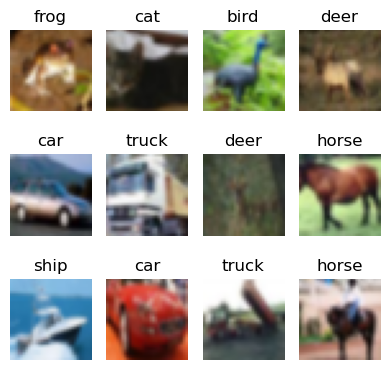

In [101]:
k = 12

image_batch = []
preds = []
for i, il in enumerate(train_dl_finetuning):
    if i == k:
        break
    image_batch.append(il[0][None,:,:,:])
    with torch.no_grad():
        outputs = model(image_batch[-1])
        preds.append(outputs.logits.argmax(-1))

labels2title = ['plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_huggingface_preds(preds=preds,images=torch.cat(image_batch),
                       label2title=labels2title,
                       rows=3,cols=4,canvas_size=4)